<a href="https://colab.research.google.com/github/qiaochen/NLPLecturePreparation/blob/master/Huggingface_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 利用[Huggingface](https://huggingface.co/transformers/installation.html#)实现的预训练语言模型做下游任务
by Qiao for NLP7 2020-8-16

预训练语言模型的用法：
1. 作为特征提取器
2. 作为encoder参与下游任务微调
使用上非常类似，差别是后者在训练过程中原预训练语言模型的参数也允许优化。

主要内容:
1. 以XLNet介绍HuggingFace transformers组件的使用套路
2. 以XLNet为例介绍如何接续下游的文本分类和抽取式问答。

主要参考[文档](https://huggingface.co/transformers/model_doc/xlnet.html)和[代码](https://github.com/huggingface/transformers/blob/0ed7c00ba6b3178c8c323a0440bf1221fb99784b/src/transformers/modeling_xlnet.py)

### 以[XLNet](https://huggingface.co/transformers/model_doc/xlnet.html)为例，使用其他Huggingface封装的预训练语言模型的套路与类似

In [1]:
import os
import torch
import torch.nn as nn
import torch.functional as F
!pip install transformers
from transformers import XLNetModel, XLNetTokenizer, XLNetConfig

In [2]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
model = XLNetModel.from_pretrained('xlnet-base-cased', 
                                   output_hidden_states=True,
                                   output_attentions=True)

### 注意：
以上使用模型名称初始化的模块，程序会在后台下载预训练完成的XLNet模型并加载。对于内地同学，除改变上网方式外，还可以手动下载模型，指定路径加载。
#### 手动下载模型：
在HuggingFace官方[模型库](https://huggingface.co/models)上找到需要下载的模型，点击模型链接，例如：[xlnet-base-cased](https://huggingface.co/xlnet-base-cased)模型。在跳转到的模型页面中点击`List all files in model`（字比较小，注意查看），将跳出框中的模型相关文(pytorch或tf版本)件保存到本地。
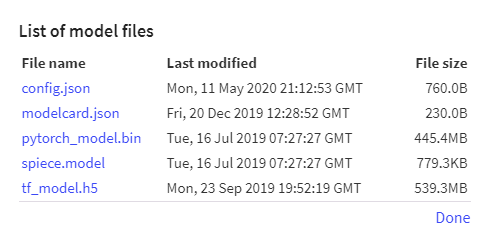

In [3]:
# # 本地加载XLNet模型
# MODEL_PATH = r"D:\data\nlp\xlnet-model/"
# config = XLNetConfig.from_json_file(os.path.join(MODEL_PATH, "xlnet-base-cased-config.json"))

# #config文件不仅用于设置模型参数，也可以用来控制模型的行为
# config.output_hidden_states = True
# config.output_attentions = True

# tokenizer = XLNetTokenizer(os.path.join(MODEL_PATH, 'xlnet-base-cased-spiece.model'))
# model = XLNetModel.from_pretrained(MODEL_PATH, config = config)

### 1. 句子到token id转换

In [4]:
# 利用tokenizer将原始的句子准备成模型输入
sentence = "This is an interesting review session"

# tokenization
tokens = tokenizer.tokenize(sentence)
print("Tokens: {}".format(tokens))

# 将token转化为ID
tokens_ids = tokenizer.convert_tokens_to_ids(tokens)
print("Tokens id: {}".format(tokens_ids))

# 添加特殊token: <cls>, <sep>
tokens_ids = tokenizer.build_inputs_with_special_tokens(tokens_ids)

# 准备成pytorch tensor
tokens_pt = torch.tensor([tokens_ids])
print("Tokens PyTorch: {}".format(tokens_pt))

# print(tokenizer.convert_ids_to_tokens([122,   27,   48, 5272,  717,    4,    3]))


Tokens: ['▁This', '▁is', '▁an', '▁interesting', '▁review', '▁session']
Tokens id: [122, 27, 48, 2456, 1398, 1961]
Tokens PyTorch: tensor([[ 122,   27,   48, 2456, 1398, 1961,    4,    3]])


In [5]:
# 偷懒的一条龙服务
tokens_pt2 = tokenizer(sentence, return_tensors="pt")
print("Tokens PyTorch: {}".format(tokens_pt2))

Tokens PyTorch: {'input_ids': tensor([[ 122,   27,   48, 2456, 1398, 1961,    4,    3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}


In [6]:
# 批处理
# padding
sentences = ["The ultimate answer to life, universe and time is 42.", "Take a towel for a space travel."]
print("Batch tokenization:\n", tokenizer(sentences)['input_ids'])
print("With Padding:\n", tokenizer(sentences, padding=True)['input_ids'])

Batch tokenization:
 [[32, 6452, 1543, 22, 235, 19, 6486, 21, 92, 27, 4087, 9, 4, 3], [3636, 24, 14680, 28, 24, 888, 1316, 9, 4, 3]]
With Padding:
 [[32, 6452, 1543, 22, 235, 19, 6486, 21, 92, 27, 4087, 9, 4, 3], [5, 5, 5, 5, 3636, 24, 14680, 28, 24, 888, 1316, 9, 4, 3]]


In [7]:
# 输入句子对：
multi_seg_input = tokenizer("This is segment A", "This is segment B")
print("Multi segment token (str): {}".format(tokenizer.convert_ids_to_tokens(multi_seg_input['input_ids'])))
print("Multi segment token (int): {}".format(multi_seg_input['input_ids']))
print("Multi segment type       : {}".format(multi_seg_input['token_type_ids']))

Multi segment token (str): ['▁This', '▁is', '▁segment', '▁A', '<sep>', '▁This', '▁is', '▁segment', '▁B', '<sep>', '<cls>']
Multi segment token (int): [122, 27, 7295, 79, 4, 122, 27, 7295, 322, 4, 3]
Multi segment type       : [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2]


### 2. 模型encoding

In [8]:
# 默认情况下，model.dev()模式下。下面使用模型Encode输入的句子
# 因为我们在config中设置模型返回每层的hidden states和注意力，再加上默认输出的最后一层隐状态，输出有3个部分
print("Is training mode ? ", model.training)

sentence = "The ultimate answer to life, universe and time is 42."

tokens_pt = tokenizer(sentence, return_tensors="pt")
print("Token (str): {}".format(
    tokenizer.convert_ids_to_tokens(tokens_pt['input_ids'][0])
    ))

final_layer_h, all_layer_h, attentions = model(**tokens_pt)

print(torch.sum(final_layer_h - all_layer_h[-1]).item())

final_layer_h.shape, len(all_layer_h), len(attentions)

Is training mode ?  False
Token (str): ['▁The', '▁ultimate', '▁answer', '▁to', '▁life', ',', '▁universe', '▁and', '▁time', '▁is', '▁42', '.', '<sep>', '<cls>']
0.0


(torch.Size([1, 14, 768]), 13, 12)

### 3. 下游任务


### 例1. 文本分类

In [9]:
class XLNetSeqSummary(nn.Module):
    
    def __init__(self, 
                 how='cls', 
                 hidden_size=768, 
                 activation=None, 
                 first_dropout=None, 
                 last_dropout=None):
        super().__init__()
        self.how = how
        self.summary = nn.Linear(hidden_size, hidden_size)
        self.activation = activation if activation else nn.GELU()
        self.first_dropout = first_dropout if first_dropout else nn.Dropout(0.5)
        self.last_dropout = last_dropout if last_dropout else nn.Dropout(0.5)

    def forward(self, hidden_states):
        """
        对隐状态序列池化或返回cls处的表示，作为句子的encoding
        Args:
            hidden_states :
                XLNet模型输出的最后层隐状态序列.
        Returns:
            : 句子向量表示
        """
        if self.how == "cls":
            output = hidden_states[:, -1]
        elif self.how == "mean":
            output = hidden_states.mean(dim=1)
        elif self.how == "max":
            output = hidden_states.max(dim=1)
        else:
            raise Exception("Summary type '{}' not implemted.".format(self.how))

        output = self.first_dropout(output)
        output = self.summary(output)
        output = self.activation(output)
        output = self.last_dropout(output)

        return output


class XLNetSentenceClassifier(nn.Module):
    
    def __init__(self,
                 num_labels,
                 xlnet_model,
                 d_model=768):
        super().__init__()
        self.num_labels = num_labels
        self.d_model = d_model
        self.transformer = xlnet_model
        self.sequence_summary = XLNetSeqSummary('cls', d_model, nn.GELU())
        self.logits_proj = nn.Linear(d_model, num_labels)
        
    def forward(self, model_inputs):
        transformer_outputs = self.transformer(**model_inputs)
            
        output = transformer_outputs[0]
        output = self.sequence_summary(output)
        logits = self.logits_proj(output)

        return logits
    
def get_loss(criterion, logits, labels):
    return criterion(logits, labels)



In [10]:
# 验证forward和反向传播

# toy examples
sentences = ["The ultimate answer to life, universe and time is 42.", 
             "Take a towel for a space travel."]
labels = torch.LongTensor([0, 1])

# 实例化各个模块
criterion = nn.CrossEntropyLoss()
classifier = XLNetSentenceClassifier(2, model, 768)
optimizer = torch.optim.AdamW(classifier.parameters())

# forward + loss
classifier.train()
optimizer.zero_grad()
logits = classifier(tokenizer(sentences, padding=True, return_tensors='pt'))
loss = get_loss(criterion, logits, labels)

print("Loss: ", loss.item())

# backwawrd step
loss.backward()
optimizer.step()

print("="*25)
print("Confirm that the gradients are computed for the original XLNet parameters.\n")
print("="*25)
for param in classifier.parameters():
    print(param.shape, param.grad.sum() if not param.grad is None else param.grad)

/usr/local/lib/python3.6/dist-packages/transformers/modeling_xlnet.py:283: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:918.)
  attn_score = (ac + bd + ef) * self.scale


Loss:  0.37429606914520264
Confirm that the gradients are computed for the original XLNet parameters.

torch.Size([1, 1, 768]) None
torch.Size([32000, 768]) tensor(4.3674)
torch.Size([768, 12, 64]) tensor(-0.0620)
torch.Size([768, 12, 64]) tensor(-0.0048)
torch.Size([768, 12, 64]) tensor(-1.9110)
torch.Size([768, 12, 64]) tensor(1.8535)
torch.Size([768, 12, 64]) tensor(1.4339)
torch.Size([12, 64]) tensor(0.3109)
torch.Size([12, 64]) tensor(-0.0349)
torch.Size([12, 64]) tensor(0.0297)
torch.Size([2, 12, 64]) tensor(-4.7185e-09)
torch.Size([768]) tensor(-0.0299)
torch.Size([768]) tensor(0.0196)
torch.Size([768]) tensor(1.5420)
torch.Size([768]) tensor(0.2207)
torch.Size([3072, 768]) tensor(12.8594)
torch.Size([3072]) tensor(-0.5156)
torch.Size([768, 3072]) tensor(-3.1910)
torch.Size([768]) tensor(0.1854)
torch.Size([768, 12, 64]) tensor(7.0323)
torch.Size([768, 12, 64]) tensor(0.7410)
torch.Size([768, 12, 64]) tensor(-2.7717)
torch.Size([768, 12, 64]) tensor(-1.5112)
torch.Size([768, 12,

### 例2. 抽取式问答(类似[SQuAD](https://rajpurkar.github.io/SQuAD-explorer/))
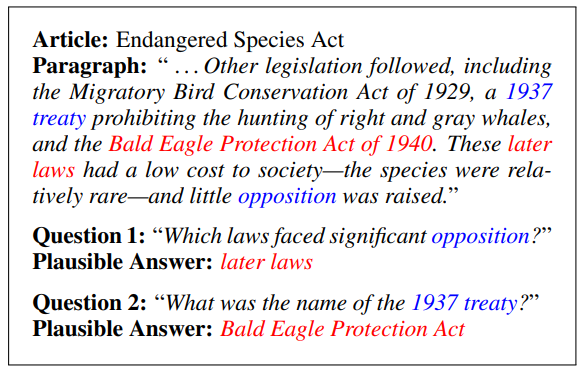

In [11]:
class AnsStartLogits(nn.Module):
    """
    用于预测每个token是否为答案span开始位置
    """
    def __init__(self, hidden_size):
        super().__init__()
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, 
                hidden_states, 
                p_mask=None
               ):
        x = self.linear(hidden_states).squeeze(-1)

        if p_mask is not None:
            x = x * (1 - p_mask) - 1e30 * p_mask
        return x
    
    
class AnsEndLogits(nn.Module):
    """
    用于预测每个token是否为答案span结束位置，符合直觉，conditioned on 开始位置
    """
    def __init__(self, hidden_size):
        super().__init__()
        self.layer = nn.Sequential(
                nn.Linear(hidden_size * 2, hidden_size),
                nn.Tanh(),
                nn.LayerNorm(hidden_size),
                nn.Linear(hidden_size, 1)
        )

    def forward(self,
                hidden_states,
                start_states,
                p_mask = None,
               ):

        x = self.layer(torch.cat([hidden_states, start_states], dim=-1))
        x = x.squeeze(-1)

        if p_mask is not None:
            x = x * (1 - p_mask) - 1e30 * p_mask
        return x
    

class XLNetQuestionAnswering(nn.Module):
    
    def __init__(self,
                 num_labels,
                 xlnet_model,
                 d_model=768,
                 top_k_start=2,
                 top_k_end=2
                 ):
        super().__init__()
        self.transformer = xlnet_model
        self.start_logits = AnsStartLogits(d_model)
        self.end_logits = AnsEndLogits(d_model)
        self.top_k_start = top_k_start # for beam search
        self.top_k_end = top_k_end # for beam search       
        
    def forward(self, 
                model_inputs,
                p_mask=None,
                start_positions=None
                ):
        """
        p_mask:
            可选的mask, 被mask掉的位置不可能存在答案(e.g. [CLS], [PAD], ...)。
            1.0 表示应当被mask. 0.0反之。
        start_positions:
            正确答案标注的开始位置。训练时需要输入模型以利用teacher forcing计算end_logits。
            Inference时不需输入，beam search返回top k个开始和结束位置。
        """
        transformer_outputs = self.transformer(**model_inputs)
        
        hidden_states = transformer_outputs[0]
        start_logits = self.start_logits(hidden_states, p_mask=p_mask)
        
        if not start_positions is None:
            # 在训练时利用 teacher forcing trick训练 end_logits
            slen, hsz = hidden_states.shape[-2:]
            start_positions = start_positions.expand(-1, -1, hsz)  # shape (bsz, 1, hsz)
            start_states = hidden_states.gather(-2, start_positions)  # shape (bsz, 1, hsz)
            start_states = start_states.expand(-1, slen, -1)  # shape (bsz, slen, hsz)
            end_logits = self.end_logits(hidden_states, 
                                         start_states=start_states, 
                                         p_mask=p_mask)
            
            return start_logits, end_logits
        else:
            # 在Inference时利用Beam Search求end_logits
            bsz, slen, hsz = hidden_states.size()
            start_probs = torch.softmax(start_logits, dim=-1)  # shape (bsz, slen)

            start_top_probs, start_top_index = torch.topk(
                start_probs, self.top_k_start, dim=-1
            )  # shape (bsz, top_k_start)
            start_top_index_exp = start_top_index.unsqueeze(-1).expand(-1, -1, hsz)  # shape (bsz, top_k_start, hsz)
            start_states = torch.gather(hidden_states, -2, start_top_index_exp)  # shape (bsz, top_k_start, hsz)
            start_states = start_states.unsqueeze(1).expand(-1, slen, -1, -1)  # shape (bsz, slen, top_k_start, hsz)

            hidden_states_expanded = hidden_states.unsqueeze(2).expand_as(
                start_states
            )  # shape (bsz, slen, top_k_start, hsz)
            p_mask = p_mask.unsqueeze(-1) if p_mask is not None else None
            end_logits = self.end_logits(hidden_states_expanded, 
                                         start_states=start_states, 
                                         p_mask=p_mask) 
            end_probs = torch.softmax(end_logits, dim=1)  # shape (bsz, slen, top_k_start)

            end_top_probs, end_top_index = torch.topk(
                end_probs, self.top_k_end, dim=1
            )  # shape (bsz, top_k_end, top_k_start)
            end_top_probs = end_top_probs.view(-1, self.top_k_start * self.top_k_end)
            end_top_index = end_top_index.view(-1, self.top_k_start * self.top_k_end)
            
            return start_top_probs, start_top_index, end_top_probs, end_top_index, start_logits, end_logits
    
def get_loss(criterion, 
             start_logits, 
             start_positions,
             end_logits,
             end_positions
            ):
    start_loss = criterion(start_logits, start_positions)
    end_loss = criterion(end_logits, end_positions)
    return (start_loss + end_loss) / 2
    
    


### 检测用于训练的forward和backward

In [12]:
context = r"""
    Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides general-purpose
    architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural
    Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between
    TensorFlow 2.0 and PyTorch.
    """
questions = [
    "How many pretrained models are available in Transformers?",
    "What does Transformers provide?",
    "Transformers provides interoperability between which frameworks?",
]

start_positions = torch.LongTensor([95, 36, 110])
end_positions = torch.LongTensor([97, 88, 123])
p_mask = [[1]*12 + [0]* (125 -14) + [1,1],
          [1]* 7 + [0]* (120 - 9) + [1,1],
          [1]*12 + [0]* (125 -14) + [1,1],
         ]

neg_log_loss = nn.CrossEntropyLoss()

q_answer = XLNetQuestionAnswering(2, model, 768, 2, 2)

optimizer = torch.optim.AdamW(q_answer.parameters())

In [13]:
q_answer.train()
optimizer.zero_grad()
for ith, question in enumerate(questions):
    start_logits, end_logits = q_answer(
        tokenizer(question, 
                  context, 
                  add_special_tokens=True,
                  return_tensors='pt'),
        p_mask=torch.ByteTensor(p_mask[ith]),
        start_positions=start_positions[ith].view(1,1,1)
    )
    loss = get_loss(
        criterion,
        start_logits, 
        start_positions[ith].view(-1),
        end_logits,
        end_positions[ith].view(-1)
    )
    print("\nTrue Start: {}, True End: {}\nPred Start Prob: {}, Pred End Prob: {}\nPred Max Start: {}, Pred Max End: {}\nPred Max Start Prob: {}, Pred Max end Prob:{}\nLoss: {}\n".format(
        start_positions[ith].item(),
        end_positions[ith].item(),
        torch.sigmoid(start_logits[:,start_positions[ith]]).item(), 
        torch.sigmoid(end_logits[:, end_positions[ith]]).item(),
        torch.argmax(start_logits).item(),
        torch.argmax(end_logits).item(),
        torch.sigmoid(torch.max(start_logits)).item(), 
        torch.sigmoid(torch.max(end_logits)).item(),
        loss.item()
        )
    )
    print("="*25)
    loss.backward()
    optimizer.step()

print("\nConfirm that the gradients are computed for the original XLNet parameters.")
for param in q_answer.parameters():
    print(param.shape, param.grad.sum() if not param.grad is None else param.grad)


True Start: 95, True End: 97
Pred Start Prob: 0.9247106313705444, Pred End Prob: 0.48027488589286804
Pred Max Start: 34, Pred Max End: 63
Pred Max Start Prob: 0.9991466999053955, Pred Max end Prob:0.6437909007072449
Loss: 6.035372734069824


True Start: 36, True End: 88
Pred Start Prob: 0.9999798536300659, Pred End Prob: 0.3708997368812561
Pred Max Start: 72, Pred Max End: 113
Pred Max Start Prob: 0.9999934434890747, Pred Max end Prob:0.4424387216567993
Loss: 4.303415775299072


True Start: 110, True End: 123
Pred Start Prob: 0.9942066669464111, Pred End Prob: 0.0
Pred Max Start: 100, Pred Max End: 63
Pred Max Start Prob: 0.9999957084655762, Pred Max end Prob:0.6812169551849365
Loss: 5.000000075237331e+29


Confirm that the gradients are computed for the original XLNet parameters.
torch.Size([1, 1, 768]) None
torch.Size([32000, 768]) tensor(0.6382)
torch.Size([768, 12, 64]) tensor(-0.0701)
torch.Size([768, 12, 64]) tensor(-0.0038)
torch.Size([768, 12, 64]) tensor(0.6484)
torch.Size([7

### inference的forward以及实现Beam Search decoding

In [14]:
import numpy as np
def decode(start_probs, end_probs, topk):
    """
    给定beam中预测的开始和结束概率，搜索topk个最佳答案
    """
    top_k_start = start_probs.shape[-1]
    top_k_end = end_probs.shape[-1] // top_k_start

    # 计算每一个(start, end)对的分数 P(start, end| sentence) = P(start|sentence) * P(end|start, sentence)
    joint_probs = dict()
    for i in range(top_k_start):
      for j in range(top_k_end):
        joint_probs[(i, j)] = start_probs[i]*end_probs[i*top_k_end+j]
    
    id_pairs, probs = zip(*sorted(joint_probs.items(), key=lambda kv:kv[1], reverse=True)[:topk])
    start_ids, end_ids = zip(*id_pairs)
    return start_ids, end_ids, probs


In [15]:
# inference
context = r"""
    Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides general-purpose
    architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural
    Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between
    TensorFlow 2.0 and PyTorch.
    """
questions = [
    "How many pretrained models are available in Transformers?",
    "What does Transformers provide?",
    "Transformers provides interoperability between which frameworks?",
]
q_answer.eval()
for ith, question in enumerate(questions):
    inputs = tokenizer(question, context, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs["input_ids"].tolist()[0]
    
    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    start_probs, start_index, end_probs, end_index, stt_logits, end_logits = q_answer(
        inputs, 
        p_mask=torch.ByteTensor(p_mask[ith])
    )

    pred_starts, pred_ends, probs = decode(
        start_probs.detach().squeeze().numpy(), 
        end_probs.detach().squeeze().numpy(), 
        2)
    
    # 只打印一个答案
    start = start_index[:, pred_starts[0]].item()
    end = end_index[:, pred_ends[0]].item()
    
#     print(probs, pred_starts, pred_ends)
#     print(len(input_ids), stt_logits.shape, end_logits.shape)
#     print(tokenizer.convert_ids_to_tokens(input_ids).index('?'))

    print("="*25)
    print("True start: {}, True end: {}".format(
        start_positions[ith].item(),
        end_positions[ith].item()
        ))
    print("Max answer prob: {:0.8f}, start idx: {}, end idx: {}".format(
        probs[0],
        start,
        end,
    ))
    print("-"*25)
    print("Question: '{}'".format(question))
    print("Answer: '{}'".format(tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[start:end]))))
    print("="*25)

True start: 95, True end: 97
Max answer prob: 0.00008147, start idx: 95, end idx: 101
-------------------------
Question: 'How many pretrained models are available in Transformers?'
Answer: '32+ pretrained models in'
True start: 36, True end: 88
Max answer prob: 0.00008149, start idx: 90, end idx: 96
-------------------------
Question: 'What does Transformers provide?'
Answer: '32+ pretrained models in'
True start: 110, True end: 123
Max answer prob: 0.00008148, start idx: 95, end idx: 101
-------------------------
Question: 'Transformers provides interoperability between which frameworks?'
Answer: '32+ pretrained models in'
